## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [2]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils

## Загружаем исходные данные

In [3]:
train = np.loadtxt('../datasets/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('../datasets/test.csv', delimiter=',', skiprows=1)

In [82]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

## Визуализируем исходные данные

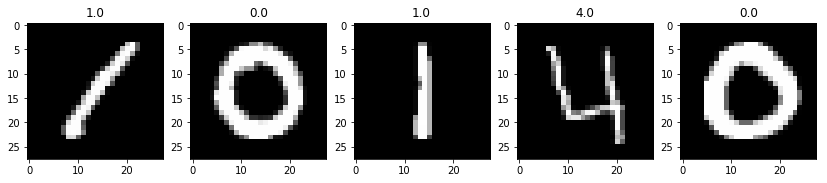

In [83]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Очищаем исходные данные

In [52]:
tstimg = train_img[0].copy()

In [53]:
mygassblur = cv2.GaussianBlur

In [54]:
tstimg = mygassblur(tstimg,ksize=(3,3),sigmaX =1)

In [55]:
tstimg.shape

(28, 28)

In [56]:
for i,img in enumerate(train_img):
    train_img[i] = cv2.GaussianBlur(img,ksize=(5,5),sigmaX =2.5)

In [57]:
for i,img in enumerate(test_img):
    test_img[i] = cv2.GaussianBlur(img,ksize=(5,5),sigmaX =2.5)

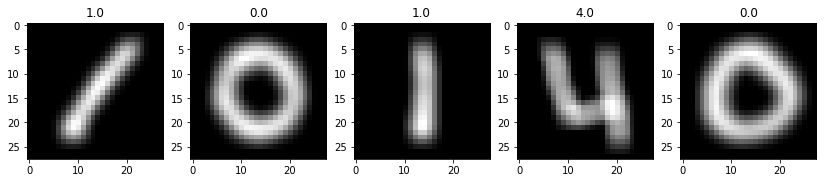

In [58]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);


In [59]:
train_img[0].shape

(28, 28)

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [84]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [85]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [86]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [87]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

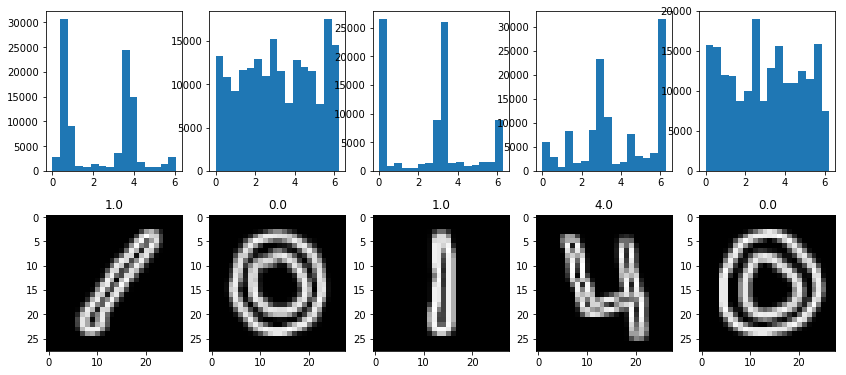

In [88]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [89]:
# Попытка развернуть все вектора в одну сторону, ухудшило результат, я убрал, но может что-то не так сделал.
# или направление, в данном случае, важно.

In [90]:
#train_theta[np.nonzero(train_theta>np.pi)] = train_theta[np.nonzero(train_theta>np.pi)] - np.pi


In [91]:
#test_theta[np.nonzero(test_theta>np.pi)] = test_theta[np.nonzero(test_theta>np.pi)] - np.pi

In [92]:
# Гистограммы вычисляются с учетом длины вектора градиента. построем гистограмму для каждой четверти отдельно.
train_hist = np.zeros((len(train_img), 64))
for i in range(len(train_img)):
    hist_up_r, borders_up_r = np.histogram(train_theta[i][:14,:14],
                                 bins=16,
                                 range=(0.,  2*np.pi),
                                 weights=train_g[i][0:14,:14])
    hist_down_r, borders_down_r = np.histogram(train_theta[i][14:,:14],
                                 bins=16,
                                 range=(0.,  2*np.pi),
                                 weights=train_g[i][14:,:14])    
    hist_up_l, borders_up_l = np.histogram(train_theta[i][:14,14:],
                                 bins=16,
                                 range=(0.,  2*np.pi),
                                 weights=train_g[i][0:14,14:])
    hist_down_l, borders_down_l = np.histogram(train_theta[i][14:,14:],
                                 bins=16,
                                 range=(0.,  2*np.pi),
                                 weights=train_g[i][14:,14:])     
  
    train_hist[i] = np.hstack([hist_up_r, hist_down_r,hist_up_l, hist_down_l])   

In [69]:
test_hist = np.zeros((len(test_img), 64))
for i in range(len(test_img)):
    hist_up_r, borders_up_r = np.histogram(test_theta[i][:14,:14],
                                 bins=16,
                                 range=(0., 2*np.pi),
                                 weights=test_g[i][:14,:14])
    hist_down_r, borders_down_r = np.histogram(test_theta[i][14:,:14],
                                 bins=16,
                                 range=(0., 2*np.pi),
                                 weights=test_g[i][14:,:14])    
    hist_up_l, borders_up_l = np.histogram(test_theta[i][:14,14:],
                                 bins=16,
                                 range=(0., 2*np.pi),
                                 weights=test_g[i][:14,14:])
    hist_down_l, borders_down_l = np.histogram(test_theta[i][14:,14:],
                                 bins=16,
                                 range=(0., 2*np.pi),
                                 weights=test_g[i][14:,14:])        
 
    test_hist[i] = np.hstack([hist_up_r, hist_down_r,hist_up_l, hist_down_l])   

## Нормируем вектор гистограммы (без нормировки получается лучше, убрал)

## Создаем классы препроцесинга для pipeline

In [148]:
class ImgBluring:
    def __init__(self):
        return(None)
    def fit(self,imglist, y,blur, size, sigmaX=1):
        self.blur = blur
        self.size = size
        self.sigmaX = sigmaX
    def transform(self,imglist, y):
        if self.blur is None:
            return(imglist)
        else:
            return(self.blur(imglist,ksize=(self.size,self.size), sigmaX= self.sigmaX))
            

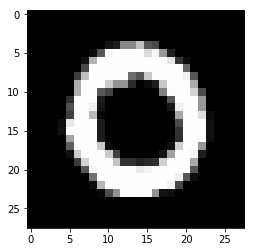

In [194]:
plt.imshow(train_img[1],  cmap='gray')

In [195]:
ttt = ImgBluring()

In [202]:
ttt.fit(train_img[1], None, cv2.GaussianBlur, 7,1)

In [203]:
ttt.transform(train_img[1], None).shape

(28, 28)

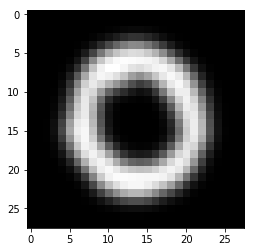

In [204]:
plt.imshow(ttt.transform(train_img[1], None), cmap='gray');


## Вычесление кластеров

In [93]:
from sklearn.cluster import KMeans
kmn = KMeans(n_clusters=8)

In [94]:
%%time
claster= {}
for label in range(0,10):
    claster[label] = kmn.fit(train_hist[np.nonzero(train_label==label)]).cluster_centers_

Wall time: 8.69 s


In [95]:
claster[9].shape

(8, 64)

## Разбиваем выборку на обучение и валидацию

In [96]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2, random_state=42)

## Вычисляем центроиды каждого из 9 классов

In [97]:
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)

In [98]:
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

## Находим ближайший центройд для валидации

In [78]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

In [99]:
pred_val_c = np.zeros_like(y_val)
for i in range(len(y_val)):
    tmp = []
    for label in list(claster.keys()):
        distances = np.linalg.norm(claster[label] - x_val[i], axis=1)
        tmp.append(np.min(distances))
    
    pred_val_c[i] = np.argmin(tmp)

## Оцениваем качество решение на валидационной выборке

In [80]:
from sklearn.metrics import accuracy_score

In [100]:
print('Accuracy: %s' % accuracy_score(y_val, pred_val_c))

Accuracy: 0.905714285714


In [19]:
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.82619047619


In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.92      0.87      0.89       816
        1.0       0.84      0.93      0.88       909
        2.0       0.89      0.81      0.85       846
        3.0       0.68      0.82      0.74       937
        4.0       0.88      0.74      0.80       839
        5.0       0.86      0.81      0.83       702
        6.0       0.82      0.84      0.83       785
        7.0       0.87      0.76      0.81       893
        8.0       0.70      0.76      0.73       835
        9.0       0.75      0.76      0.75       838

avg / total       0.82      0.81      0.81      8400



In [32]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[706   4   5  18  15  11  20   1  12  24]
 [  0 848   4   2   6   0   7  13  26   3]
 [  2   9 682  99   4   5  10   7  21   7]
 [  2   6  23 771   7  32   1   4  72  19]
 [  8  23   3  20 621   0  64   5  28  67]
 [  2   0   2  86   2 566  18   0  23   3]
 [ 23  29   2   1  28  15 659   0  27   1]
 [  2  46  32  30   1   2   2 675  36  67]
 [ 13  31  10  52  11  22  26   6 638  26]
 [ 11  19   1  60  13   2   0  68  25 639]]


## Предсказания на тестовыйх данных

In [33]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

In [ ]:
pred_test_c = np.zeros(len(test_img), np.uint8) # центроиды на базе кластеризации ищем минимальное растояние до каждого центра.
for i in range(len(test_img)):
    tmp = []
    for label in list(claster.keys()):  # сначала определяем минимальныое расстояние до центров кластера для каждой цифры
        distances = np.linalg.norm(claster[label] - test_hist[i], axis=1)
        tmp.append(np.min(distances))
    pred_test_c[i] = np.argmin(tmp) # потом определяем до какой цифры минимальное расстояние

## Визуализируем предсказания

In [34]:
import pandas as pd

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000112B62E8>]], dtype=object)

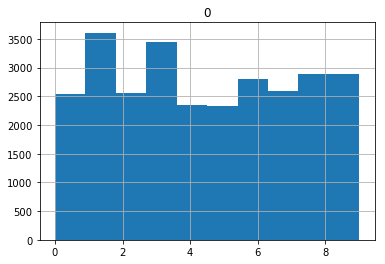

In [35]:
pd.DataFrame(pred_test).hist()

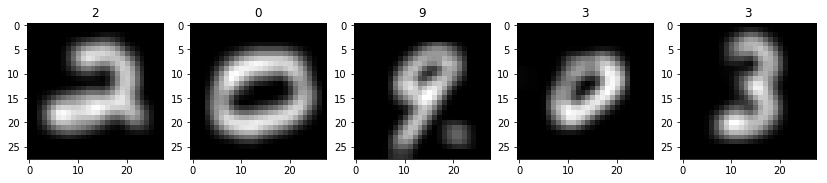

In [38]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [ ]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p)) # 0.837

In [ ]:
# Submission scored with clusters on kaggle 0.83728 (quarter and mean centroids)

In [ ]:
with open('submit_rf.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test_c, 1):
        dst.write('%s,%s\n' % (i, p))  

In [108]:
# Submission scored with clusters on kaggle 0.90157 (quarter with 8 clusters for each digit)